In [45]:
root = "/Users/andersbensen/Documents/github/synthetic_tabular_data"

In [46]:
import os
import numpy as np

os.chdir(os.path.expanduser(root))

In [47]:
from src.data import get_dataset

X, X_mean, X_std, columns, df_real = get_dataset(f"{root}/datasets/winequality-red.csv")
df = df_real.copy(deep=True)

In [48]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()

In [49]:
metadata.detect_from_dataframe(data=df)

In [28]:
from sdv.single_table import TVAESynthesizer
synthesizer = TVAESynthesizer(metadata)
synthesizer.fit(df)


/Users/andersbensen/miniforge3/envs/ws_ml/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'chlorides'. Data will not be rounded.
  warnings.warn(
/Users/andersbensen/miniforge3/envs/ws_ml/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'alcohol'. Data will not be rounded.
  warnings.warn(
/Users/andersbensen/miniforge3/envs/ws_ml/lib/python3.8/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/Users/andersbensen/miniforge3/envs/ws_ml/lib/python3.8/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strat

In [51]:
amount = df_og.shape[0]

generated = synthesizer.sample(num_rows=amount)

generated = generated.to_numpy()

In [52]:
import pandas as pd 

df_g = pd.DataFrame(generated, columns=columns)
df_fake = df_g.copy(deep=True)

df['kind'] = "real"
df_g['kind'] = "fake"

df_merged = pd.concat([df, df_g], ignore_index=True)

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns 

/var/folders/gk/b96f_3b92yx59x_09tc9d6bm0000gn/T/ipykernel_60163/3761637643.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_real_mean = df.mean().values
/var/folders/gk/b96f_3b92yx59x_09tc9d6bm0000gn/T/ipykernel_60163/3761637643.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_real_std = df.std().values
/var/folders/gk/b96f_3b92yx59x_09tc9d6bm0000gn/T/ipykernel_60163/3761637643.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_fake_mean = df_g.mean().values
/var/folde

Text(0.5, 1.0, 'Std. of each feature')

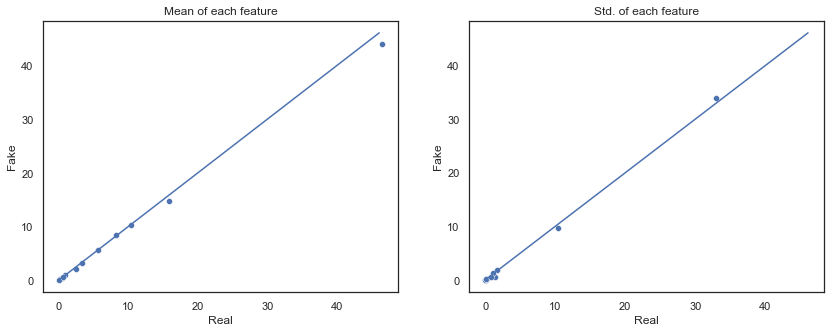

In [32]:

_, axes = plt.subplots(1, 2, figsize=(14,5))

df_real_mean = df.mean().values
df_real_std = df.std().values

df_fake_mean = df_g.mean().values
df_fake_std = df_g.std().values


min_mean = min([df_fake_mean.min(), df_real_mean.min()])
max_mean = max([df_fake_mean.max(), df_real_mean.max()])
line_mean = np.arange(min_mean, max_mean)

sns.scatterplot(df_real_mean, df_fake_mean, ax=axes[0])
sns.lineplot(x=line_mean, y=line_mean, ax=axes[0])
axes[0].set_xlabel("Real")
axes[0].set_ylabel("Fake")
axes[0].set_title("Mean of each feature")


min_std = min([df_fake_std.min(), df_real_std.min()])
max_std = max([df_fake_std.max(), df_real_std.max()])
line_std = np.arange(min_mean, max_mean)

sns.scatterplot(df_real_std, df_fake_std, ax=axes[1])
sns.lineplot(x=line_std, y=line_std, ax=axes[1])
axes[1].set_xlabel("Real")
axes[1].set_ylabel("Fake")
axes[1].set_title("Std. of each feature")


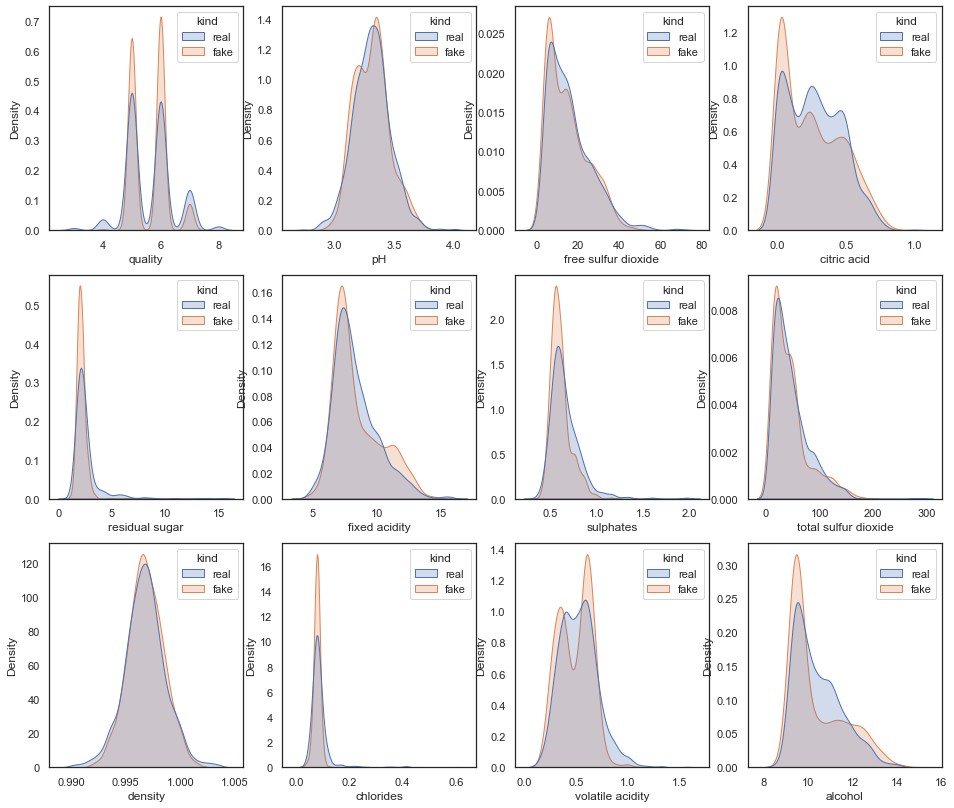

In [33]:
fig, axes = plt.subplots(3, 4, figsize=(16,14))

i, j = 0, 0 
for col in columns:
    i += 1
    j += 1

    if i == 3: i = 0
    if j == 4: j = 0
    
    sns.kdeplot(data=df_merged, x=col, hue='kind', fill=True, ax=axes[i ,j])

### How about correlation?

Text(0.5, 1.0, 'Difference')

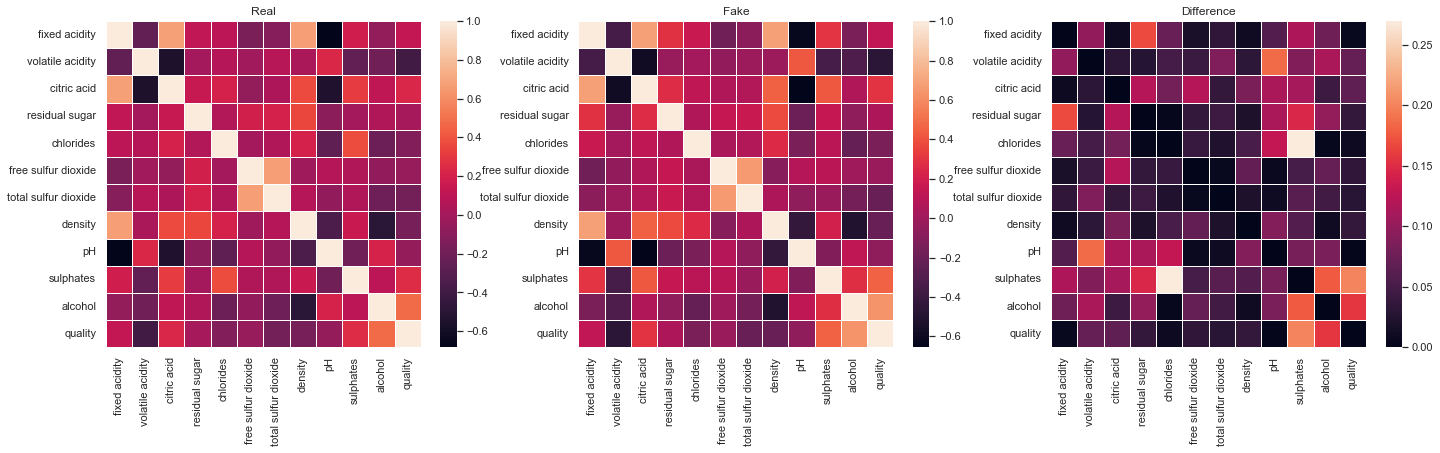

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(24,6))

sns.set(style="white")

corr_real = df.corr()
sns.heatmap(corr_real, linewidth=.5, ax=axes[0])
axes[0].set_title("Real")

corr_fake = df_g.corr()
sns.heatmap(corr_fake, linewidth=.5, ax=axes[1])
axes[1].set_title("Fake")

corr_diff = abs(corr_real - corr_fake)
sns.heatmap(corr_diff, linewidth=.5, ax=axes[2])
axes[2].set_title("Difference")


### PCA

In [35]:
X_real = ((X - X_mean) * X_std)

In [36]:
X_fake = ((generated - X_mean) * X_std) 

In [37]:
from sklearn.decomposition import PCA

pca_real = PCA(n_components=2).fit(X_real)
X_trans_real = pca_real.transform(X_real)

pca_fake = PCA(n_components=2).fit(X_fake)
X_trans_fake = pca_fake.transform(X_fake)

In [38]:
X_trans_real

array([[-412.51458521,  -23.08322539],
       [ 680.11547614,   49.46548451],
       [ 246.50862003,  -25.9045759 ],
       ...,
       [-202.9074986 ,  151.35238096],
       [ -69.54420249,  173.74070492],
       [-145.07913657,   32.14197915]])

In [39]:
outliers = np.where(X_trans_real[:,0] > 6000)
X_trans_real = np.delete(X_trans_real, outliers[0], axis=0)

Text(0.5, 1.0, 'Fake')

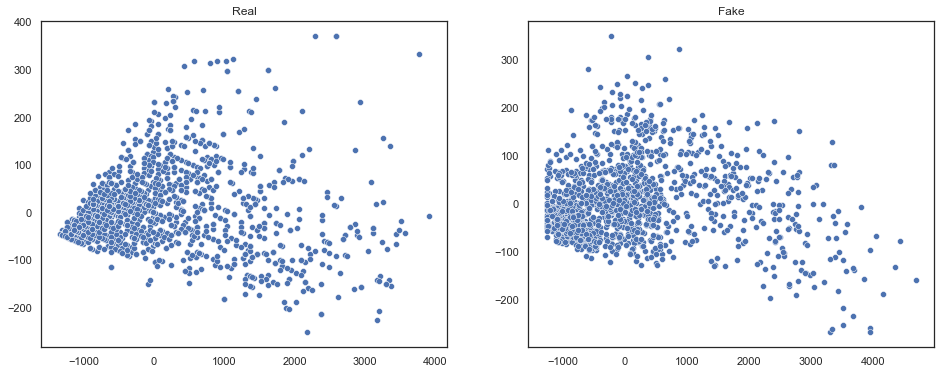

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

sns.scatterplot(x=X_trans_real[:,0], y=X_trans_real[:,1], ax=axes[0])
axes[0].set_title("Real")

sns.scatterplot(x=X_trans_fake[:,0], y=X_trans_fake[:,1], ax=axes[1])
axes[1].set_title("Fake")

In [53]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=df_real,
    synthetic_data=df_fake,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 66/66 [00:00<00:00, 446.75it/s]

Overall Quality Score: 93.38%

Properties:
- Column Shapes: 87.86%
- Column Pair Trends: 98.9%


In [54]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,fixed acidity,KSComplement,0.887430
1,volatile acidity,KSComplement,0.946842
2,citric acid,KSComplement,0.916823
3,residual sugar,KSComplement,0.738587
4,chlorides,KSComplement,0.706692
5,free sulfur dioxide,KSComplement,0.892433
6,total sulfur dioxide,KSComplement,0.883677
7,density,KSComplement,0.951845
8,pH,KSComplement,0.959350
9,sulphates,KSComplement,0.845528


In [57]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic_report = run_diagnostic(
    real_data=df_real,
    synthetic_data=df_fake,
    metadata=metadata)

diagnostic_report.get_results()

Creating report: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]


DiagnosticResults:

SUCCESS:
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


{'SUCCESS': ['Over 90% of the synthetic rows are not copies of the real data',
  'The synthetic data follows over 90% of the min/max boundaries set by the real data'],
 'WARNING': ['The synthetic data is missing more than 10% of the numerical ranges present in the real data'],
 'DANGER': []}

In [58]:

diagnostic_report.get_properties()

{'Coverage': 0.7456863043060457, 'Synthesis': 1.0, 'Boundaries': 1.0}